In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load Train Data and Labels

In [2]:
train_df = pd.read_parquet("train.parquet")
print(train_df.shape)
train_df.head()

(26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [3]:
targets = pd.read_csv("train_labels.csv")
targets["session"] = targets["session_id"].str.split("_",expand = True)[0]
targets["session"] = targets["session"].astype(int)
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
targets

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


## Feature Engineer

In [5]:
#Calculate Elapsed Time Difference Column
trainp = train_df.copy()
trainp['time_diff'] = (trainp['elapsed_time'] - trainp.groupby(['session_id','level_group'])['elapsed_time'].shift(1)).clip(0,1e7)
train = trainp.copy()
train.loc[train['time_diff'] < 0, 'time_diff'] = 0  # Assign 0 to values less than 0

In [6]:
train1 = train[train["level_group"]=='0-4']
train2 = train[train["level_group"]=='5-12']
train3 = train[train["level_group"]=='13-22']

In [7]:
CATS = ['event_name','name','fqid','room_fqid','text_fqid']

NUMS = ['page','room_coor_x','room_coor_y','screen_coor_x','screen_coor_y','hover_duration','time_diff']

EVENTS = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

NAMES = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

In [8]:
def feature_engineer(x, grp):
    
    x['elapsed_time'] = x['elapsed_time'] / 1000
    x['time_diff'] = x['time_diff'] / 1000
    
    #session duration
    df_final = x.groupby('session_id')['index'].agg('count')
    df_final.name = 'num_events'
    df_final = df_final.reset_index()
    df_final = df_final.set_index('session_id')
    
    #Bingo Features
    if grp == '5-12':
        
        df_final['logbingo-logbook'] = x[(x['fqid']=='logbook.page.bingo')&(x['event_name']=='object_click')].groupby('session_id')['index'].agg('first') - x[x['fqid']=='logbook'].groupby('session_id')['index'].agg('first')
        df_final['readerbingo-reader'] = x[(x['fqid']=='reader.paper2.bingo')&(x['event_name']=='object_click')].groupby('session_id')['index'].agg('first') - x[x['fqid']=='reader'].groupby('session_id')['index'].agg('first')
        df_final['jourbingo-journalspic'] = x[(x['fqid']=='journals.pic_2.bingo')&(x['event_name']=='object_click')].groupby('session_id')['index'].agg('first') - x[x['fqid']=='journals.pic_0.next'].groupby('session_id')['index'].agg('first')
        
        df_final['logbingo-logbook_time'] = x[(x['fqid']=='logbook.page.bingo')&(x['event_name']=='object_click')].groupby('session_id')['elapsed_time'].agg('first') - x[x['fqid']=='logbook'].groupby('session_id')['elapsed_time'].agg('first')
        df_final['readerbingo-reader_time'] = x[(x['fqid']=='reader.paper2.bingo')&(x['event_name']=='object_click')].groupby('session_id')['elapsed_time'].agg('first') - x[x['fqid']=='reader'].groupby('session_id')['elapsed_time'].agg('first')
        df_final['jourbingo-journalspic_time'] = x[(x['fqid']=='journals.pic_2.bingo')&(x['event_name']=='object_click')].groupby('session_id')['elapsed_time'].agg('first') - x[x['fqid']=='journals.pic_0.next'].groupby('session_id')['elapsed_time'].agg('first')
        
    if grp=='13-22':
        
        df_final['readerbingo-reader_flag'] = x[(x['fqid']=='reader_flag.paper2.bingo')&(x['event_name']=='object_click')].groupby('session_id')['index'].agg('first') - x[x['fqid']=='reader_flag'].groupby('session_id')['index'].agg('first')
        df_final['journalbingo-journals_flag'] = x[(x['fqid']=='journals_flag.pic_0.bingo')&(x['event_name']=='object_click')].groupby('session_id')['index'].agg('first') - x[x['fqid']=='journals_flag'].groupby('session_id')['index'].agg('first')
        
        df_final['readerbingo-reader_flag_time'] = x[(x['fqid']=='reader_flag.paper2.bingo')&(x['event_name']=='object_click')].groupby('session_id')['elapsed_time'].agg('first') - x[x['fqid']=='reader_flag'].groupby('session_id')['elapsed_time'].agg('first')
        df_final['journalbingo-journals_flag_time'] = x[(x['fqid']=='journals_flag.pic_0.bingo')&(x['event_name']=='object_click')].groupby('session_id')['elapsed_time'].agg('first') - x[x['fqid']=='journals_flag'].groupby('session_id')['elapsed_time'].agg('first')
        
    df_final['first_elapsed_time'] = x.groupby('session_id')['elapsed_time'].agg('first')
    df_final['elapsed_time'] = x.groupby('session_id')['elapsed_time'].agg('last') - df_final['first_elapsed_time']
    
    for c in CATS:
        df_final[f'{c}_nuniques'] = x.groupby('session_id')[c].agg('nunique')
    
    for c in NUMS:
        df_final[f'{c}_mean'] = x.groupby('session_id')[c].agg('mean')
        df_final[f'{c}_min'] = x.groupby('session_id')[c].agg('min')
        df_final[f'{c}_max'] = x.groupby('session_id')[c].agg('max')
        
    for c in EVENTS:
        x[c] = (x.event_name == c).astype('int8')
    for c in EVENTS:
        df_final[f'{c}_sum'] = x.groupby('session_id')[c].agg('sum')
    x.drop(EVENTS, axis=1, inplace=True)
    
    for c in EVENTS:
        df_final[f'{c}_time_mean'] = x[x['event_name']==c].groupby('session_id')['time_diff'].mean()
        df_final[f'{c}_time_min'] = x[x['event_name']==c].groupby('session_id')['time_diff'].min()
        df_final[f'{c}_time_max'] = x[x['event_name']==c].groupby('session_id')['time_diff'].max()
    
    for c in NAMES:
        x[c] = (x.name == c).astype('int8')
    for c in NAMES:
        df_final[f'{c}_sum'] = x.groupby('session_id')[c].agg('sum')
    x.drop(NAMES, axis=1, inplace=True)
    
    for c in NAMES:
        df_final[f'{c}_time_mean'] = x[x['name']==c].groupby('session_id')['time_diff'].mean()
        df_final[f'{c}_time_min'] = x[x['name']==c].groupby('session_id')['time_diff'].min()
        df_final[f'{c}_time_max'] = x[x['name']==c].groupby('session_id')['time_diff'].max()

    return df_final

In [38]:
pd.set_option('display.max_columns', 1000)

In [39]:
df1

,num_events,first_elapsed_time,elapsed_time,event_name_nuniques,name_nuniques,fqid_nuniques,room_fqid_nuniques,text_fqid_nuniques,page_mean,page_min,page_max,room_coor_x_mean,room_coor_x_min,room_coor_x_max,room_coor_y_mean,room_coor_y_min,room_coor_y_max,screen_coor_x_mean,screen_coor_x_min,screen_coor_x_max,screen_coor_y_mean,screen_coor_y_min,screen_coor_y_max,hover_duration_mean,hover_duration_min,hover_duration_max,time_diff_mean,time_diff_min,time_diff_max,cutscene_click_sum,person_click_sum,navigate_click_sum,observation_click_sum,notification_click_sum,object_click_sum,object_hover_sum,map_hover_sum,map_click_sum,checkpoint_sum,notebook_click_sum,cutscene_click_time_mean,cutscene_click_time_min,cutscene_click_time_max,person_click_time_mean,person_click_time_min,person_click_time_max,navigate_click_time_mean,navigate_click_time_min,navigate_click_time_max,observation_click_time_mean,observation_click_time_min,observation_click_time_max,notification_click_time_mean,notification_click_time_min,notification_click_time_max,object_click_time_mean,object_click_time_min,object_click_time_max,object_hover_time_mean,object_hover_time_min,object_hover_time_max,map_hover_time_mean,map_hover_time_min,map_hover_time_max,map_click_time_mean,map_click_time_min,map_click_time_max,checkpoint_time_mean,checkpoint_time_min,checkpoint_time_max,notebook_click_time_mean,notebook_click_time_min,notebook_click_time_max,basic_sum,undefined_sum,close_sum,open_sum,prev_sum,next_sum,basic_time_mean,basic_time_min,basic_time_max,undefined_time_mean,undefined_time_min,undefined_time_max,close_time_mean,close_time_min,close_time_max,open_time_mean,open_time_min,open_time_max,prev_time_mean,prev_time_min,prev_time_max,next_time_mean,next_time_min,next_time_max
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,0.0,194.860,10,3,30,7,17,NaN,NaN,NaN,7.688968,-1013.5,955.5,-71.412109,-307.750,416.00,448.410248,11.0,843.0,383.044861,60.0,639.0,2389.500000,17.0,7899.0,1.192220,0.0,30.837,28.0,22,81.0,4,8,11.0,4,4,2,1,0,1.006667,0.248,2.580,0.917591,0.000,1.774,0.904173,0.000,2.766,1.151250,0.901,1.452,1.821750,0.208,4.540,1.799000,0.533,4.949,0.170000,0.000,0.517,0.771000,0.132,1.835,0.675000,0.616,0.734,30.837,30.837,30.837,NaN,NaN,NaN,74.0,85.0,6,0,0,0,1.528137,0.000,30.837,0.885165,0.000,2.766,1.455167,0.533,2.188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090312433251036,139,0.0,233.752,11,4,22,6,11,0.000000,0.0,0.0,-84.042580,-1112.0,934.5,-53.671711,-518.500,441.00,358.223083,0.0,875.0,370.723083,58.0,639.0,1378.750000,17.0,5567.0,1.695101,0.0,37.409,36.0,18,49.0,2,5,15.0,5,3,3,1,2,1.558486,0.000,8.780,1.928444,0.203,7.984,1.419857,0.352,7.281,2.259000,1.802,2.716,1.617400,1.489,1.833,0.810733,0.000,1.901,1.002600,0.268,3.035,0.729000,0.436,1.070,0.883333,0.651,1.283,37.409,37.409,37.409,1.533500,1.018,2.049,77.0,56.0,5,1,0,0,1.984895,0.000,37.409,1.356304,0.268,7.281,1.014000,0.901,1.114,2.049000,2.049,2.049,NaN,NaN,NaN,NaN,NaN,NaN
20090312455206810,149,0.0,363.226,9,3,22,6,12,NaN,NaN,NaN,-209.827988,-1017.0,875.0,-31.124002,-240.375,450.50,373.365509,1.0,1189.0,481.268951,30.0,706.0,3145.666748,51.0,8401.0,2.467520,0.0,209.421,49.0,18,57.0,0,9,10.0,1,2,2,1,0,0.614479,0.000,5.767,0.474722,0.199,3.785,4.684930,0.000,209.421,NaN,NaN,NaN,2.002000,0.383,6.354,0.881800,0.248,2.166,0.568000,0.568,0.568,1.057500,0.680,1.435,0.924500,0.348,1.501,28.744,28.744,28.744,NaN,NaN,NaN,84.0,60.0,5,0,0,0,1.093217,0.000,28.744,4.490967,0.000,209.421,0.999600,0.248,2.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090313091715820,176,0.0,192.793,11,4,24,6,14,0.000000,0.0,0.0,-111.956871,-995.5,955.0,-76.697983,-431.750,455.50,431.910706,2.0,1006.0,441.476196,6.0,750.0,1917.142822,216.0,5794.0,1.116400,0.0,47.849,34.0,22,80.0,2,8,18.0,5,2,2,1,2,0.709000,0.000,4.784,0.591318,0.000,2.050,0.839963,0.000,8.160,1.590000,0.715,2.465,1.298000,0.000,3.301,0.940111,0.199,3.753,1.266600,0.218,4.547,1.201000,0.96

In [9]:
%%time
df1 = feature_engineer(train1.copy(), grp='0-4')
print('df1 done')
df2 = feature_engineer(train2.copy(), grp='5-12')
print('df2 done')
df3 = feature_engineer(train3.copy(), grp='13-22')
print('df3 done')

df1 done
df2 done
df3 done
CPU times: user 55.4 s, sys: 7.45 s, total: 1min 2s
Wall time: 1min 2s


In [10]:
df1

,num_events,first_elapsed_time,elapsed_time,event_name_nuniques,name_nuniques,fqid_nuniques,room_fqid_nuniques,text_fqid_nuniques,page_mean,page_min,...,close_time_max,open_time_mean,open_time_min,open_time_max,prev_time_mean,prev_time_min,prev_time_max,next_time_mean,next_time_min,next_time_max
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,0.0,194.860,10,3,30,7,17,NaN,NaN,...,2.188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090312433251036,139,0.0,233.752,11,4,22,6,11,0.000000,0.0,...,1.114,2.049000,2.049,2.049,NaN,NaN,NaN,NaN,NaN,NaN
20090312455206810,149,0.0,363.226,9,3,22,6,12,NaN,NaN,...,2.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20090313091715820,176,0.0,192.793,11,4,24,6,14,0.000000,0.0,...,1.512,1.002000,1.002,1.002,NaN,NaN,NaN,NaN,NaN,NaN
20090313571836404,112,0.0,195.851,10,4,22,6,12,0.000000,0.0,...,8.455,1.486000,0.853,2.119,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,150,0.0,554.635,11,4,28,7,18,0.000000,0.0,...,16.893,0.825000,0.825,0.825,NaN,NaN,NaN,NaN,NaN,NaN
22100215460321130,149,0.0,355.799,11,4,25,7,16,0.428571,0.0,...,8.229,2.190000,1.961,2.375,NaN,NaN,NaN,NaN,NaN,NaN
22100217104993650,197,0.0,409.659,10,4,27,7,16,0.000000,0.0,...,11.698,0.251000,0.251,0.251,NaN,NaN,NaN,NaN,NaN,NaN


# page feature 수정버전
- def2 level_group 2번째
- def3 level_group 3번째

In [11]:
def df2_new_page(X): 
    # 이상치 session_id 추출
    session_2=X[X.page==0].session_id.unique().tolist()
    X.loc[X['session_id'].isin(session_2), 'new_page'] = 0
    X.loc[~X['session_id'].isin(session_2), 'new_page'] = 1
    
    return X.groupby(['session_id']).first().reset_index()
    

def df3_new_page(X):
    session_3=X[(X.page==0)|(X.page==1)|(X.page==2)].session_id.unique().tolist()
    X.loc[X['session_id'].isin(session_3), 'new_page'] = 0
    X.loc[~X['session_id'].isin(session_3), 'new_page'] = 1
    return X.groupby(['session_id']).first().reset_index()

In [13]:
df2_=df2_new_page(train2)
T=df2_[['session_id','new_page']]
merged_df_2 = pd.merge(df2, T, on=['session_id'], how='left')
merged_df_2=merged_df_2.set_index('session_id')
merged_df_2

,num_events,logbingo-logbook,readerbingo-reader,jourbingo-journalspic,logbingo-logbook_time,readerbingo-reader_time,jourbingo-journalspic_time,first_elapsed_time,elapsed_time,event_name_nuniques,...,open_time_mean,open_time_min,open_time_max,prev_time_mean,prev_time_min,prev_time_max,next_time_mean,next_time_min,next_time_max,new_page
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,296,7,6,4,11.175,7.201,3.644,221.485,277.750,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090312433251036,395,4,28,35,13.100,37.250,23.148,266.883,550.726,11,...,1.780333,1.508,1.982,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090312455206810,245,3,5,4,3.050,6.750,2.003,380.416,252.444,11,...,3.604000,2.215,5.430,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090313091715820,326,7,12,13,17.734,34.286,14.532,232.858,515.994,11,...,1.907000,1.500,2.314,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090313571836404,242,2,6,6,5.567,12.851,6.500,220.779,306.838,11,...,0.931500,0.781,1.082,2.736000,1.602,3.870,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,299,4,6,26,25.252,33.486,64.322,601.642,967.294,11,...,2.527000,2.527,2.527,12.614333,9.051,17.417,1.644333,0.417,4.083,0.0
22100215460321130,382,4,22,8,11.148,61.612,12.030,369.202,694.581,11,...,1.919500,1.684,2.229,NaN,NaN,NaN,NaN,NaN,NaN,1.0
22100217104993650,392,3,5,18,7.580,14.296,14.447,441.324,542.998,11,...,1.392857,0.638,2.368,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [14]:
df3_=df3_new_page(train3)
T=df3_[['session_id','new_page']]
merged_df_3 = pd.merge(df3, T, on=['session_id'], how='left')
merged_df_3=merged_df_3.set_index('session_id')
merged_df_3

,num_events,readerbingo-reader_flag,journalbingo-journals_flag,readerbingo-reader_flag_time,journalbingo-journals_flag_time,first_elapsed_time,elapsed_time,event_name_nuniques,name_nuniques,fqid_nuniques,...,open_time_mean,open_time_min,open_time_max,prev_time_mean,prev_time_min,prev_time_max,next_time_mean,next_time_min,next_time_max,new_page
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,420,6,6.0,9.881,5.750,836.732,435.947,10,3,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090312433251036,1297,13,8.0,27.818,5.520,1176.483,2638.851,11,6,73,...,2.094947,0.681,5.617,1.218,1.218,1.218,1.8180,1.818,1.818,1.0
20090312455206810,364,6,10.0,9.052,14.121,747.667,441.383,11,4,47,...,2.418385,1.724,3.295,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090313091715820,491,4,NaN,8.361,NaN,976.364,645.004,11,4,54,...,2.159000,2.159,2.159,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20090313571836404,392,4,NaN,7.794,NaN,685.544,489.132,10,3,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,424,12,8.0,38.753,16.301,1916.741,55825.259,11,4,52,...,2.645750,2.359,3.424,NaN,NaN,NaN,NaN,NaN,NaN,1.0
22100215460321130,454,4,7.0,12.066,7.763,1385.001,719.500,11,4,56,...,1.630000,1.367,1.969,NaN,NaN,NaN,NaN,NaN,NaN,1.0
22100217104993650,610,5,6.0,12.962,7.815,1189.538,914.347,11,6,55,...,1.327158,0.255,1.888,0.741,0.700,0.782,1.4465,0.502,2.391,1.0


In [15]:
print(merged_df_3.shape)
print(merged_df_2.shape)
df1.shape

(23562, 102)
(23562, 104)


(23562, 97)

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23562 entries, 20090312431273200 to 22100221145014656
Data columns (total 97 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   num_events                    23562 non-null  int64  
 1   first_elapsed_time            23562 non-null  float64
 2   elapsed_time                  23562 non-null  float64
 3   event_name_nuniques           23562 non-null  int64  
 4   name_nuniques                 23562 non-null  int64  
 5   fqid_nuniques                 23562 non-null  int64  
 6   room_fqid_nuniques            23562 non-null  int64  
 7   text_fqid_nuniques            23562 non-null  int64  
 8   page_mean                     13943 non-null  float32
 9   page_min                      13943 non-null  float32
 10  page_max                      13943 non-null  float32
 11  room_coor_x_mean              23562 non-null  float32
 12  room_coor_x_min               23

# text feature 수정
- group3의 경우 worng만 존재

In [17]:
# group별 tfidf기준 correct에서 상대적으로 중요하게 나온 단어
# text 열
group1_text_corr=['thing', 'fascinating', 'yes', 'been', 'he', 'wow', 'done', 'good', 'closer', 'shouldn', 'enough', 'plus', 'great', 'ugh', 'collection', 'waiting', 'room', 'catch'] 
group2_text_corr=['cough', 'like', 'grumble', 'little', 'ooh', 'mission', 'time', 'horses', 'hold', 'wayyyy', 'while', 'yikes', 'funny', 'yup', 'sore', 'kid', 'letters', 'tiny', 'pony', 'missions', 'throat', 'blasted', 'two', 'actually', 'horse', 'or', 'hoarse', 'huh', 'ransacked', 'doesn', 'been', 'then', 'kidnapped', 'really', 'drop', 'something', 'dear', 'card', 'floor'] 
# group1_text_wron=['undefined', 'look', 'did', 'clues', 'back', 'of', 'best', 'later', 'grampa', 'them', 'ooh', 'bee', 'knees', 'love', 'photos', 'these', 'button', 'ever', 'better', 'with', 'check', 'hopefully', 'um', 'want', 'again', 'because', 'couldn', 'those', 'hooray', 'never', 'works', 'play', 'should', 'feel', 'forgetting', 'something', 'around']
# group2_text_wron=['on', 'archivist', 'should', 'go', 'out', 'stacks', 'haven', 'any', 'talk', 'university', 'well', 'figure', 'cleaning', 'so', 'capitol', 'wearing', 'check', 'better', 'upstairs', 'badgers', 'undefined', 'still', 'work', 'love', 'these', 'photos', 'button', 'jolie', 'poor', 'make', 'hear', 'loose', 'museum', 'lost', 'glasses', 'believe', 'reading', 'yeah', 'head', 'again', 'along', 'run', 'counting', 'yet', 'quite', 'figured', 'hoping', 'glass', 'u00e2', 'by', 'used', 'magnifying', 'news', 'u20ac', 'stop', 'u00a6', 'artifact', 'much', 'working', 'hmm', 'works', 'over', 'waiting', 'clue', 'clean', 'might', 'able', 'said', 'somewhere', 'weren', 'going', 'later', 'nice', 'some', 'libarian', 'information', 'seeing', 'decorations', 'such', 'day', 'fall']
# group3_text_wron=['any', 'artifact', 'by', 'if', 'right', 'digging', 'were', 'library', 'well', 'figured', 'quite', 'figure', 'stacks', 'able', 'badgers', 'friend', 'outside', 'haven', 'hoping', 'stop', 'news', 'yet', 'counting', 'door', 'they', 'funny', 'lynx', 'info', 'book', 'anyway', 'newspapers', 'loaded', 'slowing', 'fall', 'such', 'later', 'seeing', 'luck', 'ready', 'when', 'hear', 'loose', 'wearing', 'shirt', 'youmans']

In [18]:
import re
def add_text(data, col, word_list, col_name_mean, col_name_std, col_name_max):
    '''
    data= data set ex. df1, df2, df3
    col= 수정하고 싶은 열이름 str
    word_list = tfidf relative_diff (word_list)
    col_name: 새로 만들고 싶은 열이름 str
    '''
    # Create a boolean mask for rows containing the specific words
    word_mask = data[col].str.contains('|'.join(word_list), case=False)
    word_mask.fillna(False, inplace=True)
    
    # Group the data by 'session_id' and calculate the mean of 'time_diff' for the selected rows
    result1=data[word_mask].groupby('session_id')['time_diff'].mean()
    result1.reindex(data['session_id'], fill_value=0)
    result2=data[word_mask].groupby('session_id')['time_diff'].std()
    result2.reindex(data['session_id'], fill_value=0)
    result3=data[word_mask].groupby('session_id')['time_diff'].max()
    result3.reindex(data['session_id'], fill_value=0)
    
    mean_=pd.DataFrame({col_name_mean:result1})
    std_=pd.DataFrame({col_name_std:result2})
    max_=pd.DataFrame({col_name_max:result3})

    return pd.concat([mean_,std_, max_], axis=1)


In [19]:
Group1_text_corr=add_text(train1, 'text', group1_text_corr, 'corr_mean', 'corr_std', 'corr_max' )
Group2_text_corr=add_text(train2, 'text', group2_text_corr, 'corr_mean', 'corr_std', 'corr_max' )
#Group1_text_wron=add_text(train1, 'text', group1_text_wron, 'wron_mean', 'wron_std', 'wron_max' )
#Group2_text_wron=add_text(train2, 'text', group2_text_wron, 'wron_mean', 'wron_std', 'wron_max' )
#Group3_text_wron=add_text(train3, 'text', group3_text_wron, 'wron_mean', 'wron_std', 'wron_max' )

In [20]:
#데이터 합치기
merged_df_1=pd.merge(df1, Group1_text_corr, on='session_id', how='left')
merged_df_2=pd.merge(merged_df_2, Group2_text_corr, on='session_id', how='left')

In [21]:
print(merged_df_3.shape)
print(merged_df_2.shape)
merged_df_1.shape

(23562, 102)
(23562, 107)


(23562, 100)

In [22]:
merged_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23562 entries, 20090312431273200 to 22100221145014656
Data columns (total 100 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   num_events                    23562 non-null  int64  
 1   first_elapsed_time            23562 non-null  float64
 2   elapsed_time                  23562 non-null  float64
 3   event_name_nuniques           23562 non-null  int64  
 4   name_nuniques                 23562 non-null  int64  
 5   fqid_nuniques                 23562 non-null  int64  
 6   room_fqid_nuniques            23562 non-null  int64  
 7   text_fqid_nuniques            23562 non-null  int64  
 8   page_mean                     13943 non-null  float32
 9   page_min                      13943 non-null  float32
 10  page_max                      13943 non-null  float32
 11  room_coor_x_mean              23562 non-null  float32
 12  room_coor_x_min               2

- https://www.kaggle.com/code/glipko/recap-texts#Data-Extraction-
 - recap reading
 - 학생마다 점수를 표현해서 상관관계를 보는 --> scatter y축, x축(학생 스코어)
 - size

# fqid, room_fqid feature 수정 

In [23]:
# fqid 열
# group1_fqid_corr=  ['boss', 'historicalsociety'] 
# group2_fqid_corr= ['worker', 'archivist', 'bingo', 'trigger_scarf', 'what_happened', 'topics', 'trigger_coffee', 'chap2_finale_c', 'magnify', 'block_badge'] 
# group3_fqid_corr= ['pic_0', 'archivist', 'closeup', 'pic_1', 'pic_2', 'block_nelson', 'need_glasses', 'fox'] 
# group1_fqid_wron= ['plaque', 'intro', 'retirement_letter', 'tobasement', 'chap1_finale', 'report', 'janitor', 'photo', 'tostacks', 'wells', 'outtolunch', 'tocloset', 'doorblock', 'block_tomap2', 'block_tocollection', 'block_tomap1', 'block_0']
# group2_fqid_wron= ['next', 'journals', 'tunic', 'businesscards', 'reader', 'toentry', 'logbook', 'capitol_1', 'pic_2', 'historicalsociety', 'paper0', 'card_0', 'tobasement', 'pic_0', 'library', 'drycleaner', 'pic_1', 'card_1', 'paper1', 'humanecology', 'tocloset_dirty', 'boss', 'prev', 'photo', 'capitol_0', 'kohlcenter', 'door_block_talk', 'janitor', 'block_magnify', 'directory', 'tocollection', 'block', 'slip', 'outtolunch', 'block_badge_2', 'plaque']
# group3_fqid_wron=['tunic', 'reader_flag', 'toentry', 'tobasement', 'capitol_2', 'historicalsociety', 'drycleaner', 'library', 'wildlife', 'journals', 'humanecology', 'kohlcenter', 'tocloset_dirty', 'photo', 'reader', 'businesscards', 'tohallway', 'outtolunch', 'tocollection', 'pic_0_old', 'logbook', 'plaque', 'card_0', 'pic_1_old', 'pic_2_old', 'card_1', 'card_bingo']

#room_fqid열
# group2_room_corr=['drycleaner'] 
# group1_room_wrong=['basement', 'stacks']
# group2_room_wrong=['stacks', 'entry', 'microfiche', 'hall', 'capitol_1', 'basement', 'collection', 'halloffame', 'kohlcenter']
# group3_room_wrong=['hall', 'capitol_2', 'closet_dirty', 'humanecology', 'halloffame', 'kohlcenter', 'drycleaner']

# null값 제거

In [24]:
null1 = merged_df_1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = merged_df_2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = merged_df_3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(merged_df_1.columns):
    if merged_df_1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(merged_df_2.columns):
    if merged_df_2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(merged_df_3.columns):
    if merged_df_3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

6 3 0


  0%|          | 0/100 [00:00<?, ?it/s]

*********df1 DONE*********


  0%|          | 0/107 [00:00<?, ?it/s]

*********df2 DONE*********


  0%|          | 0/102 [00:00<?, ?it/s]

*********df3 DONE*********


## Train XGBoost Model

In [25]:
FEATURES1 = [c for c in merged_df_1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in merged_df_2.columns if c not in drop2+['level_group','first_index']]
FEATURES3 = [c for c in merged_df_3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = merged_df_1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 94 104 102 features
We will train with 23562 users info


In [ ]:
FEATURES1

In [26]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)),index=ALL_USERS)

In [27]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = merged_df_1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = merged_df_2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = merged_df_3
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'auto', #Change4
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    P1 = df.iloc[:,0]#Change5
    P2 = df.index #Change6
    for i, (train_index, test_index) in enumerate(gkf.split(X=P1, groups=P2)): #Change7
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            
    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)

#########################
### question 1 with features 94
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 2 with features 94
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 3 with features 94
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 4 with features 104
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 5 with features 104
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 6 with features 104
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 7 with features 104
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 8 with features 104
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 9 with features 104
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 10 with fe

## Compute CV Score

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

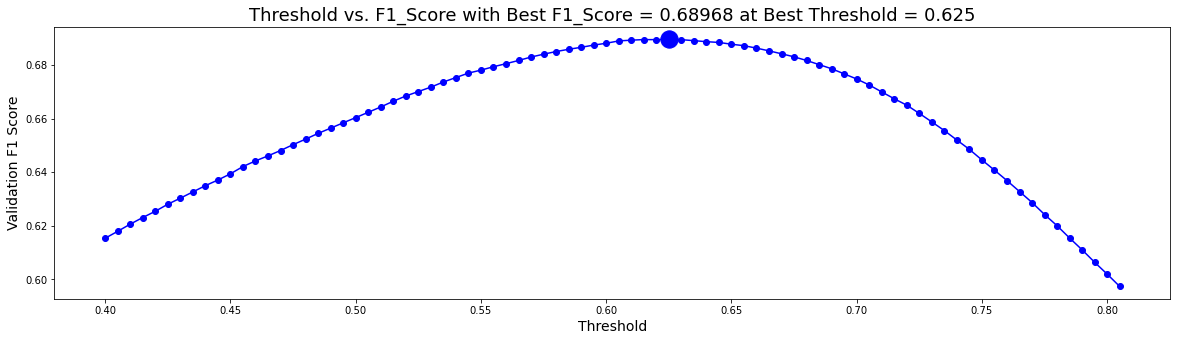

In [28]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int') #Change8
    m = f1_score(true.values.reshape((-1)), preds, average='macro') #Change9
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [29]:
print('When using optimal threshold...')
for k in range(18):
    m = f1_score(true[f'meta_{k+1}'].values, (oof_xgb[f'meta_{k+1}'].values>best_threshold_xgb).astype('int'), average='macro') #Change10
    print(f'Q{k}: F1 =',m)
    
m = f1_score(true.values.reshape((-1)), (oof_xgb.values.reshape((-1))>best_threshold_xgb).astype('int'), average='macro') #Change11
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6656940974028567
Q1: F1 = 0.504026963273597
Q2: F1 = 0.5149384923120851
Q3: F1 = 0.657601899445446
Q4: F1 = 0.6132228592304204
Q5: F1 = 0.6245132797752363
Q6: F1 = 0.613168742829578
Q7: F1 = 0.5557673256152413
Q8: F1 = 0.62541475846582
Q9: F1 = 0.5606945476337059
Q10: F1 = 0.6039358117626417
Q11: F1 = 0.5083350299094298
Q12: F1 = 0.46342934097810495
Q13: F1 = 0.6194760701730841
Q14: F1 = 0.561094296304105
Q15: F1 = 0.4755720404685509
Q16: F1 = 0.5560088130710689
Q17: F1 = 0.4906632477765845
==> Overall F1 = 0.6896791947180507


In [30]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = merged_df_1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = merged_df_2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = merged_df_3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'auto', #gpu_hist
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 94

#########################
### question 2 features 94

#########################
### question 3 features 94

#########################
### question 4 features 104

#########################
### question 5 features 104

#########################
### question 6 features 104

#########################
### question 7 features 104

#########################
### question 8 features 104

#########################
### question 9 features 104

#########################
### question 10 features 104

#########################
### question 11 features 104

#########################
### question 12 features 104

#########################
### question 13 features 104

#########################
### question 14 features 102

#########################
### question 15 features 102

#########################
### question 16 features 102

#########################
### question 17 features 102

#########################
### question 18 features 102

CPU 

In [31]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()